
# PINN Poisson 1D 

Workflow that compares: boundary enforcement (soft vs hard), architecture (1–32–1 vs 1–64–64–1), activation function (Tanh vs SiLU) and optimizer (Adam vs L-BFGS) for the 1-D Poisson BVP 

$u''(x)=e^x$ on $(0,1)$ with $u(0)=u(1)=0$.

Where

$u_{\text{true}}(x) = e^{x} + (1 - e),x - 1.$

## Setup

- Defines the 1-D Poisson problem 
- Sets up collocation and test points
- Implements automatic differentiation for $u''(x)$
- Defines the PDE residual and metric functions
- Initializes random seeds and device


In [34]:
import time, numpy as np, torch, pandas as pd  # timing, arrays, torch, tables
from torch import nn  # neural net layers
from IPython.core.magic import register_cell_magic  # allow %%skip magic
import matplotlib.pyplot as plt


@register_cell_magic  # register a no-op cell magic used in the notebook
def skip(line, cell):
    # do nothing and return successfully
    return


device = torch.device("cpu")  # force CPU device for reproducibility
torch.manual_seed(42); np.random.seed(42)  # set RNG seeds

def f_rhs(x): return torch.exp(x)  # RHS f(x)=e^x
def u_exact_np(x): return np.exp(x) + (1 - np.e) * x - 1.0  # exact solution in numpy

def make_collocation(Nc=800):
    x = torch.linspace(0, 1, Nc+2, device=device).view(-1,1)  # grid including boundaries
    x_int = x[1:-1].clone().requires_grad_(True)  # interior collocation points w/ grad
    x0 = torch.tensor([[0.0]], device=device)  # left boundary tensor
    x1 = torch.tensor([[1.0]], device=device)  # right boundary tensor
    return x_int, x0, x1  # return interior and boundary points

x_c, x0, x1 = make_collocation(800)  # build collocation set

x_test = torch.linspace(0,1,1001, device=device).view(-1,1)  # dense test grid
x_test_np = x_test.cpu().numpy().squeeze()  # numpy view of test x
u_exact_test_np = u_exact_np(x_test_np)  # exact solution on test grid

def second_derivative(u, x):
    du = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]  # u'
    d2u = torch.autograd.grad(du, x, torch.ones_like(du), create_graph=True)[0]  # u''
    return d2u  # return second derivative

def pde_residual(model, x):
    u = model(x)  # model prediction
    return second_derivative(u, x) - f_rhs(x)  # PDE residual u'' - f

def compute_metrics(model):
    # compute pointwise error metrics on x_test
    with torch.no_grad():
        u_pred = model(x_test).cpu().numpy().squeeze()  # forward pass on test grid
        err = u_pred - u_exact_test_np  # pointwise error
        RMSE  = float(np.sqrt(np.mean(err**2)))  # root-mean-square error
        RelL2 = float(np.linalg.norm(err) / np.linalg.norm(u_exact_test_np))  # relative L2
        Linf  = float(np.max(np.abs(err)))  # max absolute error
        BCcheck = float((model(x0)**2 + model(x1)**2).item())  # boundary satisfaction check
    xr = torch.linspace(0,1,2001, device=device).view(-1,1); xr.requires_grad_(True)  # dense grid for residual
    r = pde_residual(model, xr).detach().cpu().numpy().squeeze()  # residual on dense grid
    ResMean = float(np.mean(np.abs(r)))  # mean absolute residual
    ResP95  = float(np.percentile(np.abs(r), 95))  # 95th percentile residual
    return {"RMSE": RMSE, "RelL2": RelL2, "Linf": Linf, "ResMean": ResMean, "ResP95": ResP95, "BCcheck": BCcheck}  # return metrics


## Experiment 1 — Boundary enforcement (soft vs hard), 1–32–1, Tanh

- compares soft penalty vs hard trial transform $u=x(1-x)\,n_\theta$
- keeps architecture, optimizer, and sampling fixed
- trains each for 8000 Adam steps
- reports RMSE, RelL2, Linf, residual stats, and BC check


In [35]:
class MLP_32x1(nn.Module):
    def __init__(self, act=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1,32), act(), nn.Linear(32,1))  # 1→32→1 MLP
    def forward(self, x): return self.net(x)  # forward wrapper

def train_soft_bc(steps=8000, lr=2e-3, lam_bc=1.0, log_every=1000):
    model = MLP_32x1().to(device)  # instantiate model
    opt = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    t0 = time.time()  # start timer
    for it in range(1, steps+1):
        opt.zero_grad()  # zero gradients
        r = pde_residual(model, x_c); pde_loss = torch.mean(r**2)  # PDE loss
        bc_loss = (model(x0)**2 + model(x1)**2)  # BC penalty
        loss = pde_loss + lam_bc*bc_loss  # total loss
        loss.backward(); opt.step()  # backprop and step
        if it % log_every == 0:
            print(f"[SoftBC it={it}] total={loss.item():.3e} pde={pde_loss.item():.3e} bc={bc_loss.item():.3e}")  # logging
    return model, time.time()-t0  # return model and elapsed time

class HardWrap(nn.Module):
    def __init__(self, core): super().__init__(); self.core=core  # store inner network
    def forward(self, x): return x*(1-x)*self.core(x)  # enforce u(0)=u(1)=0 via multiplier

def build_hard_32(act=nn.Tanh): return HardWrap(MLP_32x1(act=act)).to(device)  # builder for hard-B.C. model

def train_hard_32(steps=8000, lr=2e-3, log_every=1000, act=nn.Tanh):
    model = build_hard_32(act=act)  # instantiate hard-B.C. model
    opt = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    t0 = time.time()  # start timer
    for it in range(1, steps+1):
        opt.zero_grad(); r = pde_residual(model, x_c); loss = torch.mean(r**2)  # PDE-only loss
        loss.backward(); opt.step()  # backprop and step
        if it % log_every == 0: print(f"[HardBC it={it}] loss={loss.item():.3e}")  # logging
    return model, time.time()-t0  # return model and elapsed time

soft_model, soft_time = train_soft_bc()  # train soft-B.C. variant
soft_metrics = compute_metrics(soft_model); soft_metrics["Variant"]="SoftBC_1x32x1_Tanh"; soft_metrics["Time"]=soft_time  # compute metrics
print(soft_metrics)  # display metrics

hard_model_32, hard_time_32 = train_hard_32()  # train hard-B.C. 32-model
hard_metrics_32 = compute_metrics(hard_model_32); hard_metrics_32["Variant"]="HardBC_1x32x1_Tanh"; hard_metrics_32["Time"]=hard_time_32  # compute metrics
print(hard_metrics_32)  # display metrics


[SoftBC it=1000] total=1.922e-03 pde=1.920e-03 bc=1.762e-06
[SoftBC it=2000] total=1.144e-03 pde=1.143e-03 bc=2.368e-08
[SoftBC it=3000] total=7.061e-04 pde=7.061e-04 bc=7.270e-09
[SoftBC it=4000] total=3.740e-04 pde=3.740e-04 bc=2.488e-09
[SoftBC it=5000] total=1.594e-04 pde=1.594e-04 bc=8.038e-10
[SoftBC it=6000] total=5.108e-05 pde=4.637e-05 bc=4.720e-06
[SoftBC it=7000] total=9.730e-06 pde=9.730e-06 bc=2.821e-11
[SoftBC it=8000] total=1.634e-05 pde=5.222e-06 bc=1.112e-05
{'RMSE': 8.518066169926897e-05, 'RelL2': 0.0005518788238987327, 'Linf': 0.00010395050048828125, 'ResMean': 0.0016222114209085703, 'ResP95': 0.004378795623779297, 'BCcheck': 1.4625445743376986e-08, 'Variant': 'SoftBC_1x32x1_Tanh', 'Time': 6.347265005111694}
[HardBC it=1000] loss=9.256e-05
[HardBC it=2000] loss=6.461e-05
[HardBC it=3000] loss=5.320e-05
[HardBC it=4000] loss=4.116e-05
[HardBC it=5000] loss=2.852e-05
[HardBC it=6000] loss=1.699e-05
[HardBC it=7000] loss=7.995e-06
[HardBC it=8000] loss=2.893e-06
{'RMSE'

## Experiment 2 — Architecture (Hard BC), Tanh

- fixes hard BC and activation
- compares 1–32–1 vs 1–64–64–1 cores
- same optimizer, steps, and sampling

In [36]:
class MLP_64x2(nn.Module):
    def __init__(self, act=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64), act(),  # first hidden layer
            nn.Linear(64,64), act(),  # second hidden layer
            nn.Linear(64,1)  # output
        )
    def forward(self, x): return self.net(x)  # forward wrapper

def build_hard_64x2(act=nn.Tanh): return HardWrap(MLP_64x2(act=act)).to(device)  # builder for larger hard-B.C. model

def train_hard_64x2(steps=8000, lr=2e-3, log_every=1000, act=nn.Tanh):
    model = build_hard_64x2(act=act)  # instantiate model
    opt = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    t0 = time.time()  # start timer
    for it in range(1, steps+1):
        opt.zero_grad(); r = pde_residual(model, x_c); loss = torch.mean(r**2)  # PDE loss
        loss.backward(); opt.step()  # backprop and step
        if it % log_every == 0: print(f"[Hard_64x2 it={it}] loss={loss.item():.3e}")  # logging
    return model, time.time()-t0  # return model and elapsed time

small_metrics = dict(compute_metrics(hard_model_32)); small_metrics["Variant"]="HardBC_1x32x1_Tanh"; small_metrics["Time"]=hard_time_32  # reuse small model metrics

hard_model_64x2, hard_time_64x2 = train_hard_64x2(act=nn.Tanh)  # train larger model
large_metrics = compute_metrics(hard_model_64x2); large_metrics["Variant"]="HardBC_1x64x64x1_Tanh"; large_metrics["Time"]=hard_time_64x2  # compute metrics

print(small_metrics); 
print(large_metrics)  # display metrics


[Hard_64x2 it=1000] loss=4.699e-05
[Hard_64x2 it=2000] loss=7.948e-06
[Hard_64x2 it=3000] loss=8.839e-07
[Hard_64x2 it=4000] loss=3.525e-07
[Hard_64x2 it=5000] loss=3.478e-07
[Hard_64x2 it=6000] loss=3.761e-07
[Hard_64x2 it=7000] loss=4.122e-07
[Hard_64x2 it=8000] loss=5.813e-05
{'RMSE': 1.14040785774705e-05, 'RelL2': 7.388612721115351e-05, 'Linf': 2.2798776626586914e-05, 'ResMean': 0.0012706960551440716, 'ResP95': 0.0030171871185302734, 'BCcheck': 0.0, 'Variant': 'HardBC_1x32x1_Tanh', 'Time': 6.710520029067993}
{'RMSE': 0.0009188220137730241, 'RelL2': 0.005952975247055292, 'Linf': 0.0012678653001785278, 'ResMean': 0.009862683713436127, 'ResP95': 0.01195979118347168, 'BCcheck': 0.0, 'Variant': 'HardBC_1x64x64x1_Tanh', 'Time': 26.54689311981201}


## Experiment 3 — Optimizer and Activation (Hard BC, 1–64–64–1): Adam vs L-BFGS; Tanh vs SiLU

- fixes PDE, sampling, and architecture
- trains Adam with Tanh and SiLU
- trains L-BFGS with Tanh and SiLU
- compares accuracy


In [37]:
def train_lbfgs(model_builder, max_iter=400):
    model = model_builder()  # build fresh model
    opt = torch.optim.LBFGS(model.parameters(), max_iter=max_iter, line_search_fn="strong_wolfe")  # L-BFGS optimizer
    def closure():
        opt.zero_grad()  # zero grads for closure
        r = pde_residual(model, x_c)  # compute residuals
        loss = torch.mean(r**2)  # mean squared residual
        loss.backward()  # compute grads
        return loss  # return loss for L-BFGS
    t0 = time.time()  # start timer
    opt.step(closure)  # run L-BFGS
    return model, time.time()-t0  # return model and time

# Adam — Tanh
adam_tanh_model, adam_tanh_time = train_hard_64x2(act=nn.Tanh)  # train via Adam
adam_tanh_metrics = compute_metrics(adam_tanh_model); adam_tanh_metrics["Variant"]="Adam_Tanh"; adam_tanh_metrics["Time"]=adam_tanh_time  # metrics
print(adam_tanh_metrics)  # show metrics

# Adam — SiLU
adam_silu_model, adam_silu_time = train_hard_64x2(act=nn.SiLU)  # train Adam with SiLU
adam_silu_metrics = compute_metrics(adam_silu_model); adam_silu_metrics["Variant"]="Adam_SiLU"; adam_silu_metrics["Time"]=adam_silu_time  # metrics
print(adam_silu_metrics)  # show metrics

# L-BFGS — Tanh
lbfgs_tanh_model, lbfgs_tanh_time = train_lbfgs(lambda: build_hard_64x2(act=nn.Tanh))  # L-BFGS run
lbfgs_tanh_metrics = compute_metrics(lbfgs_tanh_model); lbfgs_tanh_metrics["Variant"]="LBFGS_Tanh"; lbfgs_tanh_metrics["Time"]=lbfgs_tanh_time  # metrics
print(lbfgs_tanh_metrics)  # show metrics

# L-BFGS — SiLU
lbfgs_silu_model, lbfgs_silu_time = train_lbfgs(lambda: build_hard_64x2(act=nn.SiLU))  # L-BFGS with SiLU
lbfgs_silu_metrics = compute_metrics(lbfgs_silu_model); lbfgs_silu_metrics["Variant"]="LBFGS_SiLU"; lbfgs_silu_metrics["Time"]=lbfgs_silu_time  # metrics
print(lbfgs_silu_metrics)  # show metrics


[Hard_64x2 it=1000] loss=2.418e-05
[Hard_64x2 it=2000] loss=8.338e-06
[Hard_64x2 it=3000] loss=9.322e-07
[Hard_64x2 it=4000] loss=1.272e-07
[Hard_64x2 it=5000] loss=1.519e-07
[Hard_64x2 it=6000] loss=1.592e-07
[Hard_64x2 it=7000] loss=1.441e-07
[Hard_64x2 it=8000] loss=2.318e-07
{'RMSE': 3.65074556611944e-05, 'RelL2': 0.00023652894014958292, 'Linf': 5.176663398742676e-05, 'ResMean': 0.00043786398600786924, 'ResP95': 0.0009493827819824219, 'BCcheck': 0.0, 'Variant': 'Adam_Tanh', 'Time': 26.227757215499878}
[Hard_64x2 it=1000] loss=2.960e-06
[Hard_64x2 it=2000] loss=9.339e-07
[Hard_64x2 it=3000] loss=8.315e-07
[Hard_64x2 it=4000] loss=6.887e-07
[Hard_64x2 it=5000] loss=5.133e-07
[Hard_64x2 it=6000] loss=3.824e-07
[Hard_64x2 it=7000] loss=6.883e-06
[Hard_64x2 it=8000] loss=2.115e-07
{'RMSE': 5.603135832643602e-06, 'RelL2': 3.6302288208389655e-05, 'Linf': 1.0818243026733398e-05, 'ResMean': 0.00038860843051224947, 'ResP95': 0.0007996559143066406, 'BCcheck': 0.0, 'Variant': 'Adam_SiLU', 'Tim

## Summary

- gathers all metrics from prior experiments into one table
- shows RMSE, RelL2, Linf, residual stats, BC check, and time
- enables quick side-by-side comparison across variants

#### Metrics
- RMSE — root mean square error between predicted and true solution
- RelL2 — relative L2 norm error, scaled by true solution norm
- Linf — maximum absolute error across test points
- ResMean — mean absolute PDE residual across collocation points
- ResP95 — 95th percentile of absolute PDE residuals
- BCcheck — boundary condition violation magnitude
- Time — total training time in seconds


In [38]:
results = [
    soft_metrics, hard_metrics_32,
    small_metrics, large_metrics,
    adam_tanh_metrics, adam_silu_metrics,
    lbfgs_tanh_metrics, lbfgs_silu_metrics
]  # collect all run metrics

df = pd.DataFrame(results)  # build summary dataframe
print(df[["Variant","RMSE","RelL2","Linf","ResMean","ResP95","BCcheck","Time"]])  # print key columns


                 Variant      RMSE     RelL2      Linf   ResMean    ResP95  \
0     SoftBC_1x32x1_Tanh  0.000085  0.000552  0.000104  0.001622  0.004379   
1     HardBC_1x32x1_Tanh  0.000011  0.000074  0.000023  0.001271  0.003017   
2     HardBC_1x32x1_Tanh  0.000011  0.000074  0.000023  0.001271  0.003017   
3  HardBC_1x64x64x1_Tanh  0.000919  0.005953  0.001268  0.009863  0.011960   
4              Adam_Tanh  0.000037  0.000237  0.000052  0.000438  0.000949   
5              Adam_SiLU  0.000006  0.000036  0.000011  0.000389  0.000800   
6             LBFGS_Tanh  0.000002  0.000012  0.000004  0.000304  0.000638   
7             LBFGS_SiLU  0.000007  0.000043  0.000012  0.000666  0.001274   

        BCcheck       Time  
0  1.462545e-08   6.347265  
1  0.000000e+00   6.710520  
2  0.000000e+00   6.710520  
3  0.000000e+00  26.546893  
4  0.000000e+00  26.227757  
5  0.000000e+00  48.538305  
6  0.000000e+00   0.289371  
7  0.000000e+00   0.217708  


## Repeated Tests

- repeats final models multiple times with different random seeds
- computes mean and standard deviation of key metrics
- reports stability alongside accuracy (RMSE mean ± std)


In [39]:
%%skip
# Experiment — Repeat final models for mean ± std results
# defines a harness to repeat training n times and compute average/std of metrics

def repeat_runs(model_fn, n_runs=3):
    """Train the given model function n times and average results."""
    metrics_list = []  # store per-run metrics
    for i in range(n_runs):
        torch.manual_seed(42 + i)  # different seed per trial
        np.random.seed(42 + i)
        model, _ = model_fn()  # train model
        m = compute_metrics(model)  # compute metrics
        metrics_list.append(m)  # append
    df = pd.DataFrame(metrics_list)  # dataframe of trials
    avg = df.mean()  # mean metrics
    std = df.std()  # std metrics
    return avg.to_dict(), std.to_dict()  # return as dicts

# Wrap each model builder (no redefinition of classes needed)
def build_adam_tanh(): return train_hard_64x2(act=nn.Tanh)  # builder for Adam Tanh
def build_adam_silu(): return train_hard_64x2(act=nn.SiLU)  # builder for Adam SiLU
def build_lbfgs_tanh(): return train_lbfgs(lambda: build_hard_64x2(act=nn.Tanh))  # builder for L-BFGS Tanh
def build_lbfgs_silu(): return train_lbfgs(lambda: build_hard_64x2(act=nn.SiLU))  # builder for L-BFGS SiLU

# Run 3 times each
models = {
    "Adam_Tanh": build_adam_tanh,
    "Adam_SiLU": build_adam_silu,
    "LBFGS_Tanh": build_lbfgs_tanh,
    "LBFGS_SiLU": build_lbfgs_silu,
}

avg_results, std_results = [], []  # accumulate results

for name, fn in models.items():
    print(f"\nRunning {name} (3 trials)...")  # log
    avg, std = repeat_runs(fn, n_runs=3)  # run repeated trials
    avg["Variant"] = name
    std["Variant"] = name
    avg_results.append(avg)
    std_results.append(std)
    print(f"{name}: RMSE={avg['RMSE']:.2e} ± {std['RMSE']:.1e}, RelL2={avg['RelL2']:.2e} ± {std['RelL2']:.1e}")  # show summary

# Combine and print
df_avg = pd.DataFrame(avg_results)
df_std = pd.DataFrame(std_results)  # dataframes of avg/std


In [40]:
# Print mean and std tables computed by the repeat-runs harness
# (This cell expects df_avg and df_std to exist if the repeat cell was executed.)
print("\n=== Mean Metrics ===")
print(df_avg[["Variant","RMSE","RelL2","ResMean","ResP95","BCcheck"]])
print("\n=== Std Metrics ===")
print(df_std[["Variant","RMSE","RelL2","ResMean","ResP95","BCcheck"]])


=== Mean Metrics ===
      Variant      RMSE     RelL2   ResMean    ResP95  BCcheck
0   Adam_Tanh  0.000024  0.000154  0.000651  0.001338      0.0
1   Adam_SiLU  0.000081  0.000524  0.000957  0.001815      0.0
2  LBFGS_Tanh  0.000005  0.000030  0.000501  0.000997      0.0
3  LBFGS_SiLU  0.000005  0.000032  0.000508  0.000984      0.0

=== Std Metrics ===
      Variant          RMSE     RelL2   ResMean    ResP95  BCcheck
0   Adam_Tanh  2.803499e-05  0.000182  0.000254  0.000251      0.0
1   Adam_SiLU  6.290204e-05  0.000408  0.000606  0.001049      0.0
2  LBFGS_Tanh  5.798206e-06  0.000038  0.000512  0.000976      0.0
3  LBFGS_SiLU  8.556893e-07  0.000006  0.000088  0.000177      0.0


## Results

- L-BFGS models achieve the lowest RMSE (~5×10⁻⁶) and RelL2 (~3×10⁻⁵)
- Adam models show higher errors (RMSE ~2×10⁻⁵–8×10⁻⁵) and less precise fits
- Residual metrics (ResMean, ResP95) confirm tighter PDE satisfaction with L-BFGS
- BCcheck = 0 for all runs because boundary conditions fully enforced
- Adam shows large variance across runs → less stable convergence
- L-BFGS has small std values which translates to more consistent optimization
- Tanh and SiLU perform similarly under L-BFGS, with Tanh slightly better under Adam
- Optimizer choice has the largest impact; activation choice only minor for this PDE


## Evalutation Plots

Plotting the best model performing model: Hard BC, 1x64x64x1, Tanh and LBGFS

- First plot — compares the learned solution $u_{\text{PINN}}(x)$ with the exact analytic $u_{\text{true}}(x)$; close overlap shows accurate learning  
- Second plot — shows pointwise absolute error $|u_{\text{PINN}} - u_{\text{true}}|$; small and smooth errors confirm numerical stability  
- Third plot — histogram of residual magnitudes $|u_{xx} - f(x)|$; concentration near zero indicates the PDE is well satisfied across the domain


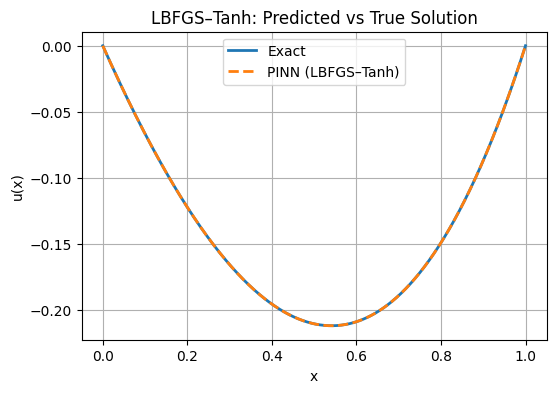

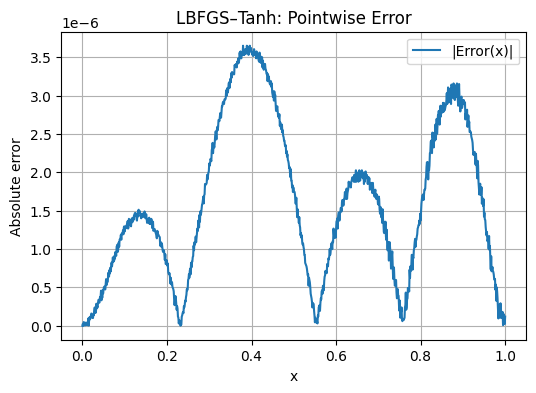

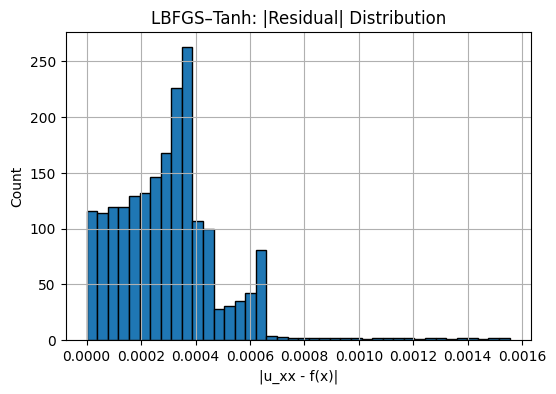

In [41]:
## Evaluation plots — Best model (LBFGS–Tanh)

# Predict on test grid
with torch.no_grad():
    u_pred = lbfgs_tanh_model(x_test).cpu().numpy().squeeze()

# 1) True vs predicted solution
plt.figure(figsize=(6,4))
plt.plot(x_test_np, u_exact_test_np, label="Exact", linewidth=2)
plt.plot(x_test_np, u_pred, "--", label="PINN (LBFGS–Tanh)", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("LBFGS–Tanh: Predicted vs True Solution")
plt.legend()
plt.grid(True)
plt.show()

# 2) Pointwise absolute error
abs_err = np.abs(u_pred - u_exact_test_np)
plt.figure(figsize=(6,4))
plt.plot(x_test_np, abs_err, label="|Error(x)|")
plt.xlabel("x")
plt.ylabel("Absolute error")
plt.title("LBFGS–Tanh: Pointwise Error")
plt.grid(True)
plt.legend()
plt.show()

# 3) Residual distribution
xr = torch.linspace(0, 1, 2001, device=device).view(-1,1)
xr.requires_grad_(True)
r_vals = pde_residual(lbfgs_tanh_model, xr).detach().cpu().numpy().squeeze()

plt.figure(figsize=(6,4))
plt.hist(np.abs(r_vals), bins=40, edgecolor='k')
plt.xlabel("|u_xx - f(x)|")
plt.ylabel("Count")
plt.title("LBFGS–Tanh: |Residual| Distribution")
plt.grid(True)
plt.show()
